In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism
import json

In [33]:
class Node:
    def __init__(self, name=None, bitwidth=None, operation=None, operands=None, 
                 idNum=None, value=-1, pos=None, FuncIO=None, start=None, width=None):
        self.name = name
        self.bitwidth = bitwidth
        self.operation = operation
        self.operands = operands
        self.idNum = idNum
        self.value = value
        self.pos = pos
        self.FuncIO = FuncIO
        self.start = start
        self.width = width

    def __repr__(self):
        return f"Node(name={self.name}, bitwidth={self.bitwidth}, operation={self.operation}, operands={self.operands}, id={self.idNum}, value={self.value}, pos={self.pos}, FuncIO={self.FuncIO}, start={self.start}, width={self.width})"

def node_to_dict(node):
    return {
        "OperationName": node.name,
        "BitWidth": node.bitwidth,
        "OperationType": node.operation,
        "Operands": node.operands,
        "idNum": node.idNum,
        "Value": node.value,
        "Pos": node.pos,
        "FuncIO": node.FuncIO,
        "Start": node.start,
        "Width": node.width
    }
    
def ParseIRFile(ir_text):
    nodes_dict = {}
    lines = ir_text.strip().split("\n")[:] 
    return lines

def LineToDict(line):
    nodes = []
    # Check for function header
    FuncIO = "Not"
    if "fn" in line:
        FuncIO = "In"
        # Extract everything between ( and )
        args_str = re.search(r'\((.*?)\)', line).group(1)
        # Split by comma to get individual arguments
        args = args_str.split(',')
        for arg in args:
            # Extract name and bitwidth
            name, bit_info = [s.strip() for s in arg.split(':')]
            bitwidth = int(re.search(r'bits\[(\d+)\]', bit_info).group(1))
            # Create a Node object for each argument
            node = Node(name=name, bitwidth=bitwidth, FuncIO=FuncIO)
            nodes.append(node)
        return nodes
    if "ret" in line:
        FuncIO = "Out"
        line = line[4:]
        
    if line == "}":
        return None

    # Extract node name
    name = re.search(r"(\w+\.\d+):", line).group(1)

    # Extract bitwidth
    bitwidth = int(re.search(r"bits\[(\d+)\]", line).group(1))

    # Extract operation
    operation = re.search(r"= (\w+)", line).group(1)

    # Extract operands; filter out the operation, "value", "id", and "pos"
    operands = re.findall(r"(\w+\.\d+|\w+)", line.split("=")[1])
    operands = [op for op in operands if op not in [operation, "value", "id", "pos", "start", "width"]]


    # Extract id
    idNum = int(re.search(r"id=(\d+)", line).group(1))

    # Extract value (if present)
    value_match = re.search(r"value=(\d+)", line)
    value = int(value_match.group(1)) if value_match else -1

    # Extract pos (if present)
    pos_match = re.search(r"pos=\[\((\d+,\d+,\d+)\)\]", line)
    pos = tuple(map(int, pos_match.group(1).split(","))) if pos_match else None

    # Extract start and width for bit_slice (if present)
    start = None
    width = None
    if operation == "bit_slice":
        start = int(re.search(r"start=(\d+)", line).group(1))
        width = int(re.search(r"width=(\d+)", line).group(1))

    # Create Node object
    node = Node(name, bitwidth, operation, operands, idNum, value, pos, FuncIO, start, width)
    
    # Add to node list
    nodes.append(node)
    return nodes

def DictToGraph(G, NodeDict):
    # This function turns the node dictionary to directional graph
    NodeList = []
    EdgeList = []
    for NodeName in NodeDict:
        if NodeDict[NodeName].FuncIO != "In": 
            # This if is for handling the function top input, they are treated as nodes as well.
            NodeList.append((NodeDict[NodeName].idNum, node_to_dict(NodeDict[NodeName])))
            for ParentName in NodeDict[NodeName].operands:
                if NodeDict[ParentName].FuncIO != "In":
                    EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                else: 
                    EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
        else:
            NodeList.append((NodeDict[NodeName].name, node_to_dict(NodeDict[NodeName])))

    G.add_nodes_from(NodeList)
    G.add_edges_from(EdgeList)
    return G
    

In [34]:
def slice_ir_by_function(ir_content):
    # Regular expression to match function definitions with and without "top"
    fn_pattern = re.compile(r"(?:top\s+)?fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")

    # Split the content by lines for processing
    lines = ir_content.split('\n')

    # Dictionary to store each function's IR content
    functions_dict = {}

    # Buffer to store current function lines
    current_fn = None
    current_fn_lines = []

    # Iterate through each line
    for line in lines:
        # Check if the line starts a new function definition
        match = fn_pattern.match(line)
        if match:
            # If there is a current function being processed, save it
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn_lines = []
            # Start a new function
            current_fn = match.group(1)
        # Add the line to the current function's lines
        if current_fn:
            current_fn_lines.append(line)
        # Check if the line ends a function definition
        if line.strip() == '}':
            # Save the current function and reset
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn = None
                current_fn_lines = []

    # Return the dictionary with function names as keys and IR content as values
    return functions_dict



In [121]:
# Define the custom matcher
class CustomMatcher(isomorphism.DiGraphMatcher):
    def __init__(self, G1, G2, node_match=None, edge_match=None, pattern_name=''):
        super().__init__(G1, G2, node_match, edge_match)
        self.pattern_name = pattern_name
        
    def semantic_feasibility(self, n1, n2):
        # For mul, we treat them both as 'mul', this gets handled by the subsitution module
        if self.G2.nodes[n2].get('OperationType') == 'mul':
            if self.G1.nodes[n1].get('OperationType') not in ['umul', 'smul']:
                return False
        elif self.G1.nodes[n1].get('OperationType') != self.G2.nodes[n2].get('OperationType'): #and self.G2.nodes[n2].get('OperationType') != None:
            return False
        
        # For now we do not allow any reference to the nodes inside one subgraph
        if self.G1.out_degree(n1) > 1:
            return False
        
        # Apply pattern-specific rules
        if self.pattern_name == 'MulAssociativity':
            return self.rule_mul_associativity(n1)
        elif self.pattern_name == 'SumSame':
            return self.rule_sum_same(n1)
        elif self.pattern_name == 'MulSumSame':
            return self.rule_mul_sum_same(n1) 
        elif self.pattern_name == 'SubToNeg':
            return self.rule_sub_to_neg(n1)
        elif self.pattern_name == 'MulByTwo':
            return self.rule_mul_by_two(n1)
        
        
        return True

    def rule_mul_associativity(self, n1):
#         return self.G1.out_degree(n1) == 1 
        return True
    
    def rule_sum_same(self, n1):
        operands = self.G1.nodes[n1].get('Operands', [])
        if operands is None:
            return False  
        return len(operands) == 2 and operands[0] == operands[1]

    
    def rule_mul_sum_same(self, n1):
        # Check if the operands satisfy subsitution requirement
        mul_operands = self.G1.nodes[n1].get('Operands', [])
        successors = list(self.G1.successors(n1))
        if self.G1.nodes[n1].get('OperationType') in ['umul', 'smul']:
            add_node = successors[0]
            add_operands = self.G1.nodes[add_node].get('Operands', [])
            shared_operand = set(mul_operands) & set(add_operands)
            # Check if the addition has exactly two operands and one is the shared operand
            if len(add_operands) == 2 and shared_operand:
                return True
            return False
        else:
            return True
        
    def rule_sub_to_neg(self, n1):
        print("[Warning] Subtraction to Negative should be disabled if dealing with unsigned values")
        #ToDo: We need to check if datatype supports negative value
        return True
        
    def rule_mul_by_two(self, n1):
        if self.G1.nodes[n1].get('OperationType') in ['umul', 'smul']:
            mul_operands = self.G1.nodes[n1].get('Operands', [])
            for operand in mul_operands:
                if operand.startswith('literal.'):
                    literal_id = operand.split('.')[1]
                    try:
                        literal_id = int(literal_id)
                    except ValueError:
                        continue
                    operand_node = self.G1.nodes.get(literal_id)
                    if operand_node and operand_node.get('OperationType') == 'literal' and operand_node.get('Value') == 2:
                        return True
        elif self.G1.nodes[n1].get('OperationType') == 'literal':
            if self.G1.nodes[n1].get('Value') == 2:
                return True
        return False

    

class SubgraphPatterns:
    def __init__(self):
        self.patterns = [
            {"name": "MulAssociativity", "pattern": self.pattern_mul_mul},
            {"name": "AddAssociativity", "pattern": self.pattern_add_add},
            {"name": "MulDistributivity", "pattern": self.pattern_mul_add},
            {"name": "SumSame", "pattern": self.pattern_sum_same},
            {"name": "MulSumSame", "pattern": self.pattern_mul_sum_same},
            {"name": "SubToNeg", "pattern": self.pattern_sub_to_neg},
            {"name": "MulByTwo", "pattern": self.pattern_mul_by_two}
        ]

    def pattern_mul_add(self):
        P = nx.DiGraph()
        P.add_node('add', OperationType='add')
        P.add_node('mul', OperationType='mul')
        P.add_edge('add', 'mul')
        return P

    def pattern_add_add(self):
        P = nx.DiGraph()
        P.add_node('add1', OperationType='add')
        P.add_node('add2', OperationType='add')
        P.add_edge('add1', 'add2')
        return P

    def pattern_mul_mul(self):
        P = nx.DiGraph()
        P.add_node('mul1', OperationType='mul')
        P.add_node('mul2', OperationType='mul')
        P.add_edge('mul1', 'mul2')
        return P
    
    def pattern_sum_same(self):
        P = nx.DiGraph()
        P.add_node('add', OperationType='add')
        return P
    
    def pattern_mul_sum_same(self):
        P = nx.DiGraph()
        P.add_node('mul', OperationType='mul')
        P.add_node('add', OperationType='add')
        P.add_edge('mul', 'add')
        return P
    
    def pattern_sub_to_neg(self):
        P = nx.DiGraph()
        P.add_node('sub', OperationType='sub')
        return P
    
    def pattern_mul_by_two(self):
        P = nx.DiGraph()
        P.add_node('literal', OperationType='literal')
        P.add_node('mul', OperationType='mul')
        P.add_edge('literal', 'mul')
        return P


# Match subgraphs against the main graph
def match_subgraphs(G):
    AllSubGraph = []
    pattern_obj = SubgraphPatterns()
    for pattern_info in pattern_obj.patterns:
        P = pattern_info["pattern"]()
        GM = CustomMatcher(G, P, node_match=lambda n1, n2: n1.get('OperationType') == n2.get('OperationType'), pattern_name=pattern_info["name"])
        for SubGraph in GM.subgraph_isomorphisms_iter():
            SubGraph["SubType"] = pattern_info['name']
            AllSubGraph.append(SubGraph)
    return AllSubGraph



In [129]:
# Node(name=None, bitwidth=None, operation=None, operands=None, 
#                  idNum=None, value=None, pos=None, FuncIO=None, start=None, width=None)


# {'add1': 28, 'add2': 24}
# {'add': 22, 'mul': 23}

class SubsitutionHandler:
    def __init__(self):
        self.subhandlers = {
            "MulAssociativity": self.handle_mul_associativity,
            "AddAssociativity": self.handle_add_associativity,
            "MulDistributivity": self.handle_mul_distributivity,
            "SumSame" : self.handle_sum_same,
            "MulSumSame" : self.handle_mul_sum_same,
            "SubToNeg" : self.handle_sub_to_neg,
            "MulByTwo" : self.handle_mul_by_two
            # Add more mappings as needed
        }

    def handle_mul_associativity(self, G, SubDict, counter):
        # a*(b*c) -> b*(a*c)
        NodesInvolved = []
        MulName = G.nodes[SubDict['mul1']]['OperationType']
        MulType = self.map_mul_type(MulName)
        OperandList = G.nodes[SubDict['mul1']]['Operands'] + G.nodes[SubDict['mul2']]['Operands']
        OperandList = self.remove_entries(OperandList, [G.nodes[SubDict['mul1']]['OperationName'], G.nodes[SubDict['mul2']]['OperationName']])
        NewNodeDict1 = node_to_dict(Node(MulName+str(counter), G.nodes[SubDict['mul1']]['BitWidth'], MulType, [OperandList[0],OperandList[2]]))
        NewNodeDict1["ReplaceSelfWith"] = "Gen"
        NewNodeDict2 = node_to_dict(Node(MulName+str(counter + 1), G.nodes[SubDict['mul2']]['BitWidth'], MulType, [OperandList[1], MulName+str(counter)]))
        NewNodeDict2["ReplaceSelfWith"] = "Gen"
        OldNodeDict1 = G.nodes[SubDict['mul1']]
        OldNodeDict1["ReplaceSelfWith"] = "Kill"
        OldNodeDict2 = G.nodes[SubDict['mul2']]
        OldNodeDict2["ReplaceSelfWith"] = MulName+str(counter + 1)
        NodesInvolved = [NewNodeDict1, NewNodeDict2, OldNodeDict1, OldNodeDict2]
        return NodesInvolved, counter+2

    def handle_add_associativity(self, G, SubDict, counter):
        # a+(b+c) -> b+(a+c)
        NodesInvolved = []
        OperandList = G.nodes[SubDict['add1']]['Operands'] + G.nodes[SubDict['add2']]['Operands']
        OperandList = self.remove_entries(OperandList, [G.nodes[SubDict['add1']]['OperationName'], G.nodes[SubDict['add2']]['OperationName']])
        NewNodeDict1 = node_to_dict(Node("add"+str(counter), G.nodes[SubDict['add1']]['BitWidth'], 'kAdd', [OperandList[0],OperandList[2]]))
        NewNodeDict1["ReplaceSelfWith"] = "Gen"
        NewNodeDict2 = node_to_dict(Node("add"+str(counter + 1), G.nodes[SubDict['add2']]['BitWidth'], 'kAdd', [OperandList[1], "add"+str(counter)]))
        NewNodeDict2["ReplaceSelfWith"] = "Gen"
        OldNodeDict1 = G.nodes[SubDict['add1']]
        OldNodeDict1["ReplaceSelfWith"] = "Kill"
        OldNodeDict2 = G.nodes[SubDict['add2']]
        OldNodeDict2["ReplaceSelfWith"] = "add"+str(counter + 1)
        NodesInvolved = [NewNodeDict1, NewNodeDict2, OldNodeDict1, OldNodeDict2]
        return NodesInvolved, counter+2

    def handle_mul_distributivity(self, G, SubDict, counter):
        # a*(b+c) -> a*b+a*c
        # add->mul
        NodesInvolved = []
        MulName = G.nodes[SubDict['mul']]['OperationType']
        MulType = self.map_mul_type(MulName)
        AddOperandList = G.nodes[SubDict['add']]['Operands']
        MulOperandList = self.remove_entries(G.nodes[SubDict['mul']]['Operands'], [G.nodes[SubDict['add']]['OperationName']])
        NewMulNodeDict1 = node_to_dict(Node(MulName+str(counter), G.nodes[SubDict['add']]['BitWidth'], MulType, [MulOperandList[0],AddOperandList[0]]))
        NewMulNodeDict1["ReplaceSelfWith"] = "Gen"
        NewMulNodeDict2 = node_to_dict(Node(MulName+str(counter+1), G.nodes[SubDict['add']]['BitWidth'], MulType, [MulOperandList[0],AddOperandList[1]]))
        NewMulNodeDict2["ReplaceSelfWith"] = "Gen"
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+2), G.nodes[SubDict['mul']]['BitWidth'], 'kAdd', [MulName+str(counter), MulName+str(counter+1),]))
        NewAddNodeDict["ReplaceSelfWith"] = "Gen"
        OldMulNodeDict = G.nodes[SubDict['mul']]
        OldMulNodeDict["ReplaceSelfWith"] = 'add'+str(counter+2)
        OldAddNodeDict = G.nodes[SubDict['add']]
        OldAddNodeDict["ReplaceSelfWith"] = "Kill"
        NodesInvolved = [NewMulNodeDict1, NewMulNodeDict2, NewAddNodeDict, OldMulNodeDict, OldAddNodeDict]                    
        return NodesInvolved, counter+3
     
    def handle_sum_same(self, G, SubDict, counter):
        # a+a -> a*2
        #ToDo: The signed mul handling is not done for this
        NodesInvolved = []
        AddOperandList = G.nodes[SubDict['add']]['Operands']
        NewLiteralDict = node_to_dict(Node('literal'+str(counter), -1, 'Literal', value=2))
        NewLiteralDict["ReplaceSelfWith"] = 'Gen'
        NewMultNodeDict = node_to_dict(Node('umul'+str(counter+1), G.nodes[SubDict['add']]['BitWidth'], 'kUMul', [AddOperandList[0],'literal'+str(counter)]))
        NewMultNodeDict["ReplaceSelfWith"] = 'Gen'
        OldAddNodeDict = G.nodes[SubDict['add']]
        OldAddNodeDict["ReplaceSelfWith"] = 'umul'+str(counter+1)
        NodesInvolved = [NewLiteralDict, NewMultNodeDict, OldAddNodeDict]
        return NodesInvolved, counter+2

# Node(name=None, bitwidth=None, operation=None, operands=None, 
#                  idNum=None, value=None, pos=None, FuncIO=None, start=None, width=None)

    def handle_mul_sum_same(self, G, SubDict, counter):
        # (a*b)+b -> (a+1)*b
        NodesInvolved = []
        MulName = G.nodes[SubDict['mul']]['OperationType']
        MulType = self.map_mul_type(MulName)
        MulOperandList = G.nodes[SubDict['mul']]['Operands'] # [a,b]
        OperandListB = self.remove_entries(G.nodes[SubDict['add']]['Operands'], G.nodes[SubDict['mul']]['OperationName']) #B
        OperandListA = self.remove_entries(MulOperandList, OperandListB) #A
        NewLiteralDict = node_to_dict(Node('literal'+str(counter), G.nodes[SubDict['add']]['BitWidth'], 'Literal', value=1))
        NewLiteralDict['ReplaceSelfWith'] = 'Gen'
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+1), G.nodes[SubDict['add']]['BitWidth'], 'kAdd', [OperandListA[0], 'literal'+str(counter)]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        NewMulNodeDict = node_to_dict(Node(MulName+str(counter+2), G.nodes[SubDict['mul']]['BitWidth'], MulType, ['add'+str(counter+1), OperandListB[0]]))
        NewMulNodeDict['ReplaceSelfWith'] = 'Gen'
        OldMulNodeDict = G.nodes[SubDict['mul']]
        OldMulNodeDict['ReplaceSelfWith'] = 'Kill'
        OldMAddNodeDict = G.nodes[SubDict['add']]
        OldMAddNodeDict['ReplaceSelfWith'] = MulName+str(counter+2)
        NodesInvolved = [NewLiteralDict, NewAddNodeDict, NewMulNodeDict, OldMulNodeDict, OldMAddNodeDict]
        return NodesInvolved, counter+3
    
    def handle_sub_to_neg(self, G, SubDict, counter):
        # a-b -> a+(-b)
        NodesInvolved = []
        OperandList = G.nodes[SubDict['sub']]['Operands'] #[a, b]
        NewNegNodeDict = node_to_dict(Node('neg'+str(counter), G.nodes[SubDict['sub']]['BitWidth'], 'kNeg', [OperandList[1]]))
        NewNegNodeDict['ReplaceSelfWith'] = 'Gen'
        NewAddNodeDict = node_to_dict(Node('add'+str(counter+1), G.nodes[SubDict['sub']]['BitWidth'], 'kAdd', [OperandList[0], 'neg'+str(counter)]))
        NewAddNodeDict['ReplaceSelfWith'] = 'Gen'
        OldSubNodeDict = G.nodes[SubDict['sub']]
        OldSubNodeDict['ReplaceSelfWith'] = 'add'+str(counter+1)
        NodesInvolved = [NewNegNodeDict, NewAddNodeDict, OldSubNodeDict]
        return NodesInvolved, counter+2
    
    def handle_mul_by_two(self, G, SubDict, counter):
        # a*2 -> a<<1
        NodesInvolved = []
        OperandList = G.nodes[SubDict['mul']]['Operands']
        OperandList = self.remove_entries(OperandList, [G.nodes[SubDict['literal']]['OperationName']]) #A
        NewLiteralNodeDict = node_to_dict(Node('literal'+str(counter), 1, 'Literal', value=1))
        NewLiteralNodeDict['ReplaceSelfWith'] = 'Gen'
        NewShllNodeDict = node_to_dict(Node('shll'+str(counter+1), G.nodes[SubDict['mul']]['BitWidth'], 'kShll',[OperandList[0], 'literal'+str(counter)]))
        NewShllNodeDict['ReplaceSelfWith'] = 'Gen'
        OldMulNodeDict = G.nodes[SubDict['mul']]
        OldMulNodeDict['ReplaceSelfWith'] = 'shll'+str(counter+1)
        OldLiteralNodeDict = G.nodes[SubDict['literal']]
        OldLiteralNodeDict['ReplaceSelfWith'] = 'Kill'
        NodesInvolved = [NewLiteralNodeDict, NewShllNodeDict, OldMulNodeDict, OldLiteralNodeDict]
        return NodesInvolved, counter
    
    
    # The following functions in this class are helper functions and handler
    #
    def map_mul_type(self, OperationType):
        # Takes in an operation type string from a mul node dictionary, translate it to a node type for Json OperationType
        if OperationType == 'umul':
            return 'kUMul'
        elif OperationType == 'smul':
            return 'kSMul'
        else:
            return None
    
    def reverse_dict_exclude_keys(self, input_dict, exclude_keys):
        return {value: key for key, value in input_dict.items() if key not in exclude_keys}
    
    def remove_entries(self, operand_list, to_remove):
        # Helper function to isolate operands
        return [op for op in operand_list if op not in to_remove]

    def handle_subsitution(self, G, SubDict, counter):
        SubType = SubDict["SubType"]
        handler = self.subhandlers.get(SubType)
        RevSubDict = self.reverse_dict_exclude_keys(SubDict, ["SubType"])
        if handler:
            return handler(G, RevSubDict, counter)
        else:
            print("[ERROR] Unknown SubType")
            return None


package my_package

file_number 1 "././work_space/test.cc"

top fn AddAssociativity(x1: bits[32], y1: bits[32], z1: bits[32]) -> bits[32] {
  add.1: bits[32] = add(z1, x1, id=1)
  ret add.2: bits[32] = add(add.1, y1, id=2)
}

fn Unsigned_MulAssociativity(x2: bits[32], y2: bits[32], z2: bits[32]) -> bits[32] {
  umul.3: bits[32] = umul(z2, x2, id=3)
  ret umul.4: bits[32] = umul(umul.3, y2, id=4)
}

fn MulDistribution(x3: bits[32], y3: bits[32], z3: bits[32]) -> bits[32] {
  add.5: bits[32] = add(z3, x3, id=5)
  ret umul.6: bits[32] = umul(add.5, y3, id=6)
}

fn SumSame(x4: bits[32]) -> bits[32] { 
  ret add.7: bits[32] = add(x4, x4, id=7)
}

fn MulSumSame(x5: bits[32], y5: bits[32], z5: bits[32]) -> bits[32] { 
  umul.8: bits[32] = umul(x5, y5, id=8)
  add.9: bits[32] = add(umul.8, z5, id=9)
  umul.10: bits[32] = umul(x5, y5, id=10)
  ret add.11: bits[32] = add(umul.10, y5, id=11)
}

fn Signed_MulAssociativity(x6: bits[32], y6: bits[32], z6: bits[32]) -> bits[32] {
  smul.12: bits[32] 

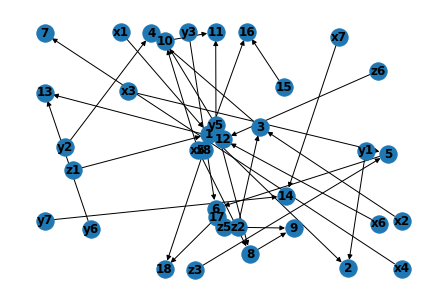

In [130]:
file_path = "/home/miao/xls/work_space/all_unit_test.ir"
# file_path = "/home/miao/xls/work_space/test.opt.ir"
# file_path = "/home/miao/xls/work_space/UNROLL.opt.ir"

# Open the file and read its contents
with open(file_path, 'r') as f:
    ir_content = f.read()
    ir_dict = slice_ir_by_function(ir_content)

print(ir_content)

FuncNodeDict = {}
for fn_name, fn_content in ir_dict.items():
    NodeDict = {}
    Lines = ParseIRFile(fn_content)
    for Line in Lines:
        NodeList = LineToDict(Line)
        if NodeList != None:
            for NodeObj in NodeList:
                NodeDict[NodeObj.name] = NodeObj
    FuncNodeDict[fn_name] = NodeDict

SubCounter = 0
NodeCounter = 0
JsonOutDict = {}
for fn_name, fn_nodes in FuncNodeDict.items():
    G = nx.DiGraph()
    G = DictToGraph(G, fn_nodes)
    G.graph['FuncName'] = fn_name

    
    nx.draw(G, with_labels=True, font_weight='bold')

    AllSubDict = match_subgraphs(G) 
    # This contains all the suggestions from the graph matcher
    handler = SubsitutionHandler()
    for SubDict in AllSubDict:
        # If we need to add an RL controler, this would be the place to do it
        JsonOutDict[str(SubCounter)] = {}
        JsonOutDict[str(SubCounter)]['FuncName'] = fn_name
        subsitution_instruction, NodeCounter = handler.handle_subsitution(G, SubDict, NodeCounter)
        JsonOutDict[str(SubCounter)]['NodesInvolved'] = subsitution_instruction
        SubCounter += 1
        print(SubDict)
        

with open('test_ins.json', 'w') as json_file:
    json.dump(JsonOutDict, json_file, indent=4)     
  